In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [ ]:
def weighted_mse_loss(predictions, targets, threshold=1.0, high_weight=5.0, low_weight=1.0):
    weights = torch.where(targets > threshold,
                          torch.tensor(high_weight, dtype=predictions.dtype, device=predictions.device),
                          torch.tensor(low_weight, dtype=predictions.dtype, device=predictions.device))
    loss = weights * (predictions - targets) ** 2
    return loss.mean()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Training-rain-data.csv to Training-rain-data.csv


In [ ]:
rainfall_data = pd.read_csv('Training-rain-data.csv')
rainfall_data.head()

,station,valid,lon,lat,elevation,p01m
0,IAH,2012-01-01 09:40:00,-95.3607,29.9844,28.0,0.0001
1,IAH,2012-01-01 09:50:00,-95.3607,29.9844,28.0,0.0001
2,IAH,2012-01-01 09:53:00,-95.3607,29.9844,28.0,0.0001
3,IAH,2012-01-04 01:53:00,-95.3607,29.9844,28.0,0.0000
4,IAH,2012-01-04 07:15:00,-95.3607,29.9844,28.0,0.0000


In [ ]:
rainfall_data = rainfall_data[['valid', 'p01m']]
rainfall_data.head()

,valid,p01m
0,2012-01-01 09:40:00,0.0001
1,2012-01-01 09:50:00,0.0001
2,2012-01-01 09:53:00,0.0001
3,2012-01-04 01:53:00,0.0000
4,2012-01-04 07:15:00,0.0000


In [ ]:
rainfall_data['valid'] = pd.to_datetime(rainfall_data['valid'])
rainfall_data = rainfall_data.sort_values('valid')
rainfall_data.head()

,valid,p01m
0,2012-01-01 09:40:00,0.0001
1,2012-01-01 09:50:00,0.0001
2,2012-01-01 09:53:00,0.0001
3,2012-01-04 01:53:00,0.0000
4,2012-01-04 07:15:00,0.0000


In [ ]:
rainfall_values = rainfall_data['p01m'].values
print(rainfall_values[:100])

[1.00e-04 1.00e-04 1.00e-04 0.00e+00 0.00e+00 0.00e+00 1.00e-04 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e-04 3.30e+00 1.00e-04 2.03e+00
 1.00e-04 2.50e-01 1.00e-04 1.00e-04 1.00e-04 1.00e-04 1.00e-04 1.00e-04
 5.10e-01 2.79e+00 8.89e+00 9.14e+00 1.78e+00 2.03e+00 2.79e+00 4.06e+00
 2.29e+00 2.50e-01 5.10e-01 2.03e+00 3.30e+00 3.81e+00 7.60e-01 1.00e-04
 1.00e-04 2.50e-01 2.50e-01 1.00e-04 1.00e-04 1.00e-04 1.00e-04 1.00e-04
 1.00e-04 1.00e-04 1.00e-04 1.00e-04 1.00e-04 2.50e-01 2.50e-01 5.10e-01
 1.02e+00 1.02e+00 1.02e+00 1.00e-04 1.00e-04 1.00e-04 1.00e-04 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00]


In [ ]:
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        x.append(seq)
        y.append(label)
    return np.array(x), np.array(y)

x, y = create_sequences(rainfall_values, seq_length=24)
#print("x shape: ", x.shape)
#print("y shape: ", y.shape)



In [ ]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# normalizing the inputs
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# turn them into torch tensors
x_tensor = torch.tensor(x_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

print("x_tensor" , x_tensor.shape)
print("y_tensor" , y_tensor.shape)

x_tensor torch.Size([93232, 24])
y_tensor torch.Size([93232, 1])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class RainDataset(Dataset):
  def __init__(self, x_tensor, y_tensor):
    self.x = x_tensor
    self.y = y_tensor

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return (self.x[index], self.y[index])

In [ ]:
dataset = RainDataset(x_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
class RainfallModel(nn.Module):
  def __init__(self, input_size=1, hidden_size=128, num_layers=2):
    super(RainfallModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x = x.unsqueeze(-1)
    lstm_out, _ = self.lstm(x)
    last_output = lstm_out[:, -1, :]
    output = self.fc(last_output)
    return output

In [ ]:
model = RainfallModel()
# criterion = nn.SmoothL1Loss()
#criterion = lambda output, target: weighted_mse_loss(output, target, threshold=1.0, weight_multiplier=5.0)
#criterion = lambda output, target: weighted_mse_loss(output, target, threshold=1.0, high_weight=5.0, low_weight=1.0)
#criterion = lambda output, target: weighted_mse_loss(output, target, threshold=1.0, weight_multiplier=5.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 100

for epoch in range(num_epochs):
  model.train()
  total_loss = 0

  for batch_x, batch_y in train_loader:
    optimizer.zero_grad()
    output = model(batch_x)
    #loss = criterion(output, batch_y)
    # Composite loss: weighted MSE (for peaks) + regular MSE (for low-rain precision)
    # Use only weighted loss to emphasize peaks
    #loss = weighted_mse_loss(output, batch_y, threshold=0.3, high_weight=8.0)
    alpha = 0.65  # how much to prioritize peaks
    weighted = weighted_mse_loss(output, batch_y, threshold=1.0, high_weight=5.0)
    regular = nn.MSELoss()(output, batch_y)
    loss = alpha * weighted + (1 - alpha) * regular
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  average_loss = total_loss / len(train_loader)
  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

Epoch 1/100, Loss: 0.0003
Epoch 2/100, Loss: 0.0002
Epoch 3/100, Loss: 0.0002
Epoch 4/100, Loss: 0.0002
Epoch 5/100, Loss: 0.0002
Epoch 6/100, Loss: 0.0002
Epoch 7/100, Loss: 0.0002
Epoch 8/100, Loss: 0.0002
Epoch 9/100, Loss: 0.0002
Epoch 10/100, Loss: 0.0002
Epoch 11/100, Loss: 0.0002
Epoch 12/100, Loss: 0.0002
Epoch 13/100, Loss: 0.0002
Epoch 14/100, Loss: 0.0002
Epoch 15/100, Loss: 0.0002
Epoch 16/100, Loss: 0.0002
Epoch 17/100, Loss: 0.0002
Epoch 18/100, Loss: 0.0002
Epoch 19/100, Loss: 0.0002
Epoch 20/100, Loss: 0.0002
Epoch 21/100, Loss: 0.0002
Epoch 22/100, Loss: 0.0002
Epoch 23/100, Loss: 0.0002
Epoch 24/100, Loss: 0.0002
Epoch 25/100, Loss: 0.0002
Epoch 26/100, Loss: 0.0002
Epoch 27/100, Loss: 0.0002
Epoch 28/100, Loss: 0.0002
Epoch 29/100, Loss: 0.0002
Epoch 30/100, Loss: 0.0002
Epoch 31/100, Loss: 0.0002
Epoch 32/100, Loss: 0.0002
Epoch 33/100, Loss: 0.0002
Epoch 34/100, Loss: 0.0002
Epoch 35/100, Loss: 0.0002
Epoch 36/100, Loss: 0.0002
Epoch 37/100, Loss: 0.0002
Epoch 38/1

In [ ]:
from google.colab import files
uploaded = files.upload()

validation_data = pd.read_csv('validation-rain-data.csv')
validation_data = validation_data[['valid', 'p01m']]
validation_data['valid'] = pd.to_datetime(validation_data['valid'])
validation_data = validation_data.sort_values('valid')

Saving validation-rain-data.csv to validation-rain-data.csv


In [ ]:
# make into numpy array
val_rainfall_values = validation_data['p01m'].values


val_x, val_y = create_sequences(val_rainfall_values, seq_length=24)

print("val_x shape:", val_x.shape)
print("val_y shape:", val_y.shape)

val_x shape: (19960, 24)
val_y shape: (19960,)


In [ ]:
# normalize using same scalars used in training
val_x_scaled = scaler_x.transform(val_x)
val_y_scaled = scaler_y.transform(val_y.reshape(-1, 1))

# make them torch tensors
val_x_tensor = torch.tensor(val_x_scaled, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y_scaled, dtype=torch.float32)

In [ ]:
print(val_x_tensor.shape)
print(val_y_tensor.shape)

torch.Size([19960, 24])
torch.Size([19960, 1])


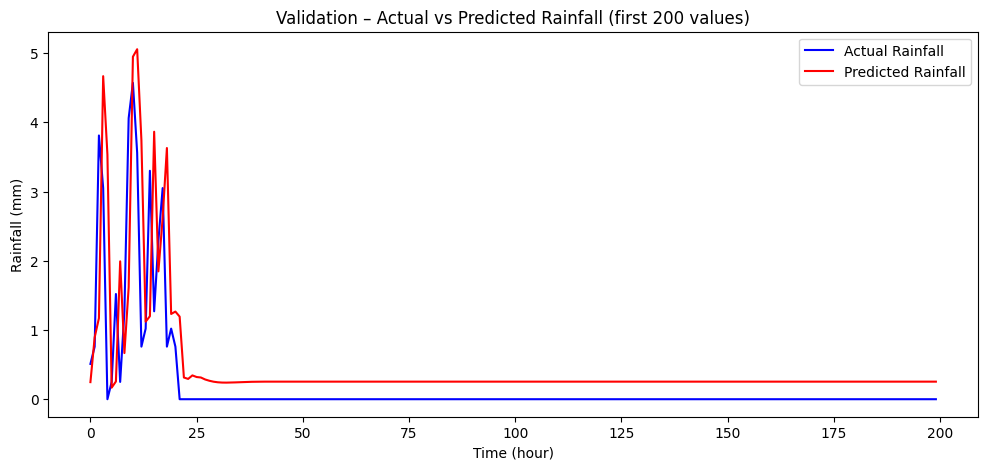

In [ ]:
# evaluate the model
model.eval()

with torch.no_grad():
    val_predictions = model(val_x_tensor).squeeze().numpy()
    val_actuals = val_y_tensor.squeeze().numpy()

# reverse the scaling
val_predictions = scaler_y.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
val_actuals = scaler_y.inverse_transform(val_actuals.reshape(-1, 1)).flatten()

# make a plot to compare acc and predicted
plt.figure(figsize=(12, 5))
plt.plot(val_actuals[:200], label='Actual Rainfall', color='blue')
plt.plot(val_predictions[:200], label='Predicted Rainfall', color='red')
plt.title('Validation – Actual vs Predicted Rainfall (first 200 values)')
plt.xlabel('Time (hour)')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


#  metrics
mae = mean_absolute_error(val_actuals, val_predictions)
rmse = np.sqrt(mean_squared_error(val_actuals, val_predictions))
r2 = r2_score(val_actuals, val_predictions)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  0.4197
RMSE: 1.3116
R²:   0.4683


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Data Preprocessing

df = pd.read_csv("/content/combine.csv")
df['valid'] = pd.to_datetime(df['valid'])
df = df.sort_values('valid')
df_rain = df[['valid', 'p01m']].copy()
df_rain.set_index('valid', inplace=True)
df_rain = df_rain.fillna(0)

# Normalize
scaler = MinMaxScaler()
df_rain['p01m'] = scaler.fit_transform(df_rain[['p01m']])



In [ ]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        seq = data[i:i+window_size]
        label = data[i+window_size]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

window_size = 24
rain_values = df_rain['p01m'].values
X, y = create_sequences(rain_values, window_size)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)


train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)


In [ ]:
import torch.nn as nn

class RainfallModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(RainfallModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Use output from last time step
        return out


In [ ]:
def weighted_mse_loss(output, target, threshold=1.0, high_weight=5.0):
    weights = torch.where(target > threshold, high_weight, 1.0)
    return torch.mean(weights * (output - target) ** 2)


In [ ]:
import torch.optim as optim

model = RainfallModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 45
alpha = 0.32  # weight for peak-focused loss

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)

        weighted_loss = weighted_mse_loss(output, batch_y, threshold=1.0, high_weight=5.0)
        mse_loss = nn.MSELoss()(output, batch_y)
        loss = alpha * weighted_loss + (1 - alpha) * mse_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/45, Loss: 0.0003
Epoch 2/45, Loss: 0.0002
Epoch 3/45, Loss: 0.0002
Epoch 4/45, Loss: 0.0002
Epoch 5/45, Loss: 0.0002
Epoch 6/45, Loss: 0.0002
Epoch 7/45, Loss: 0.0002
Epoch 8/45, Loss: 0.0002
Epoch 9/45, Loss: 0.0002
Epoch 10/45, Loss: 0.0002
Epoch 11/45, Loss: 0.0002
Epoch 12/45, Loss: 0.0002
Epoch 13/45, Loss: 0.0002
Epoch 14/45, Loss: 0.0002
Epoch 15/45, Loss: 0.0002
Epoch 16/45, Loss: 0.0002
Epoch 17/45, Loss: 0.0002
Epoch 18/45, Loss: 0.0002
Epoch 19/45, Loss: 0.0002
Epoch 20/45, Loss: 0.0002
Epoch 21/45, Loss: 0.0002
Epoch 22/45, Loss: 0.0002
Epoch 23/45, Loss: 0.0002
Epoch 24/45, Loss: 0.0002
Epoch 25/45, Loss: 0.0002
Epoch 26/45, Loss: 0.0002
Epoch 27/45, Loss: 0.0002
Epoch 28/45, Loss: 0.0002
Epoch 29/45, Loss: 0.0002
Epoch 30/45, Loss: 0.0002
Epoch 31/45, Loss: 0.0002
Epoch 32/45, Loss: 0.0002
Epoch 33/45, Loss: 0.0002
Epoch 34/45, Loss: 0.0002
Epoch 35/45, Loss: 0.0002
Epoch 36/45, Loss: 0.0002
Epoch 37/45, Loss: 0.0002
Epoch 38/45, Loss: 0.0002
Epoch 39/45, Loss: 0.

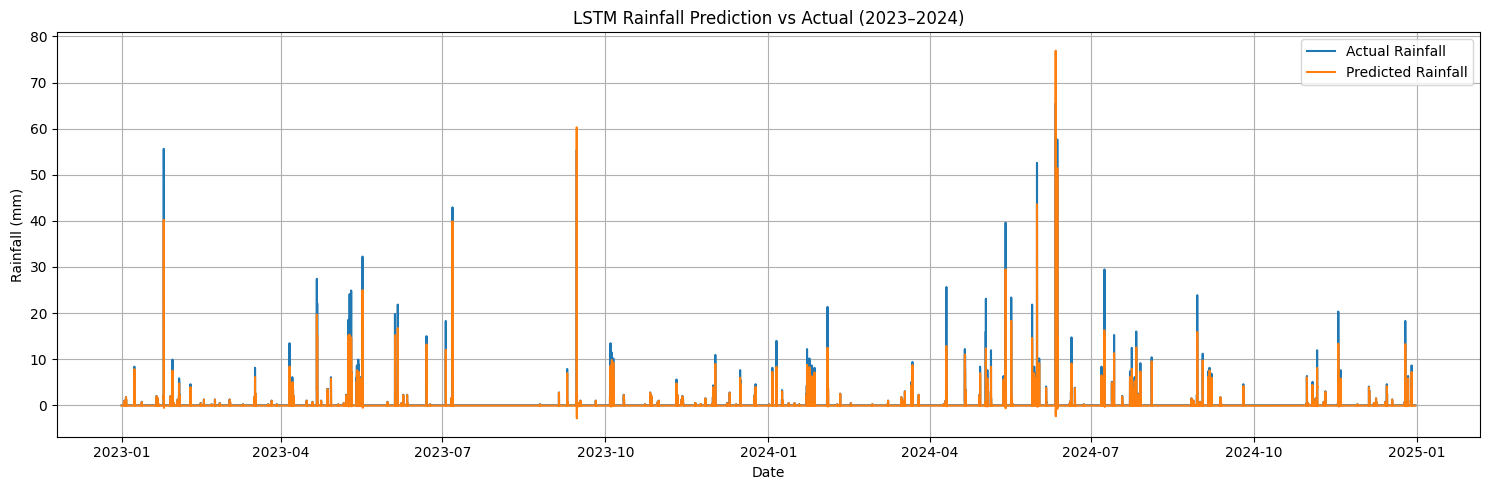

In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze().numpy()
    y_true = y_test_tensor.squeeze().numpy()

from sklearn.preprocessing import MinMaxScaler

# Use the scaler from earlier to invert scale
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_true_inv = scaler.inverse_transform(y_true.reshape(-1,1)).flatten()

test_start_idx = len(df_rain) - len(y_true_inv)
timestamps = df_rain.index[test_start_idx:test_start_idx + len(y_true_inv)]

import matplotlib.pyplot as plt


df_plot = pd.DataFrame({
    'Actual': y_true_inv,
    'Predicted': y_pred_inv
}, index=timestamps)

# Filter to only show from 2023-01-01 to 2024-12-31
df_plot = df_plot[(df_plot.index >= '2023-01-01') & (df_plot.index <= '2024-12-31')]

# Plot the actual vs predicted rainfall
plt.figure(figsize=(15,5))
plt.plot(df_plot.index, df_plot['Actual'], label='Actual Rainfall')
plt.plot(df_plot.index, df_plot['Predicted'], label='Predicted Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('LSTM Rainfall Prediction vs Actual (2023–2024)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


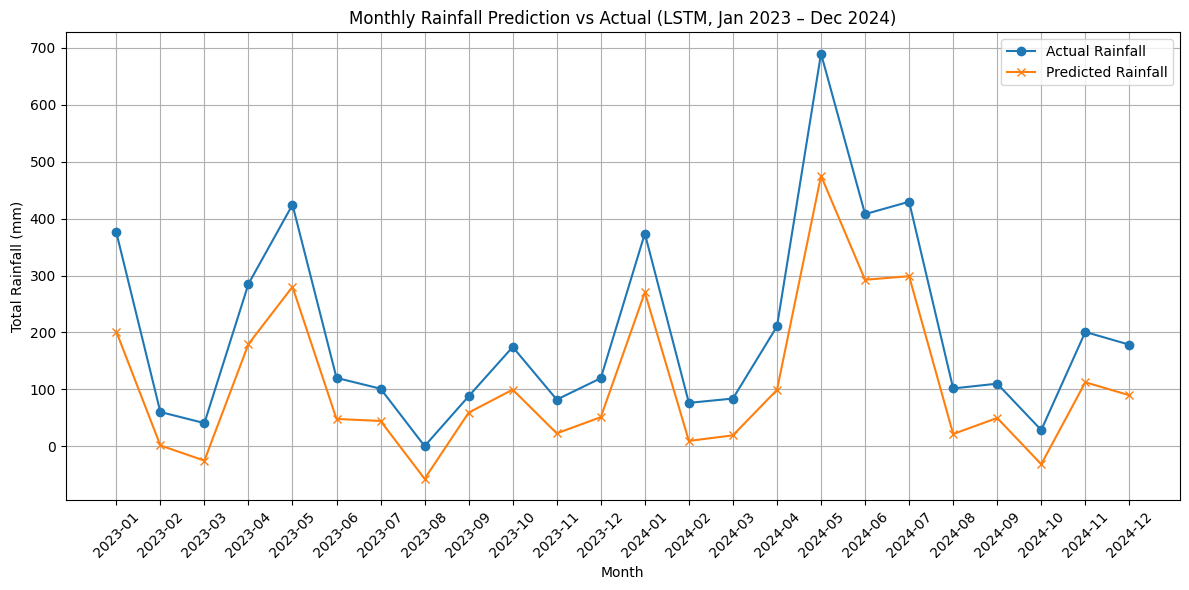

In [ ]:
# Assuming y_true_inv, y_pred_inv, and timestamps are defined as before
df_test = pd.DataFrame({
    'valid': timestamps,
    'actual': y_true_inv,
    'predicted': y_pred_inv
}).reset_index(drop=True)

# Create year_month period for grouping
df_test['year_month'] = df_test['valid'].dt.to_period('M')
monthly = df_test.groupby('year_month')[['actual', 'predicted']].sum().reset_index()
monthly['year_month'] = monthly['year_month'].astype(str)

#  Filter to show only months from Jan 2023 to Dec 2024
monthly = monthly[(monthly['year_month'] >= '2023-01') & (monthly['year_month'] <= '2024-12')]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly['year_month'], monthly['actual'], marker='o', label='Actual Rainfall')
plt.plot(monthly['year_month'], monthly['predicted'], marker='x', label='Predicted Rainfall')
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Rainfall (mm)")
plt.title("Monthly Rainfall Prediction vs Actual (LSTM, Jan 2023 – Dec 2024)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


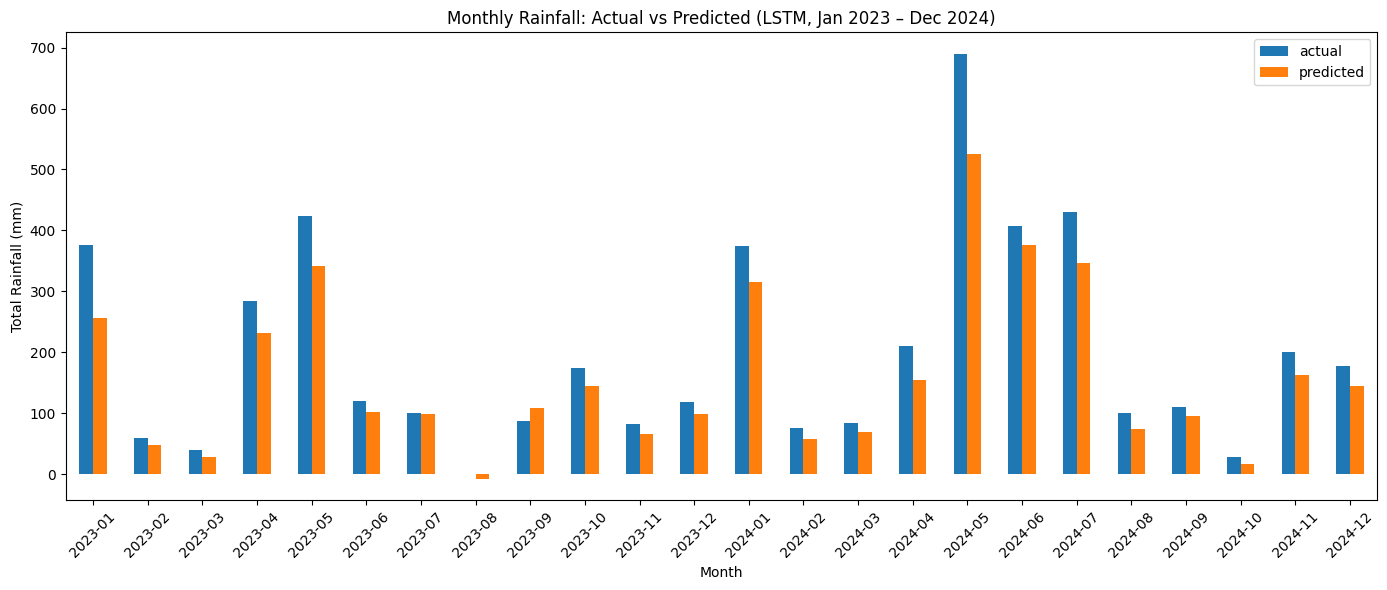

In [ ]:
# Filter to show only months from Jan 2023 to Dec 2024
monthly_filtered = monthly[(monthly['year_month'] >= '2023-01') & (monthly['year_month'] <= '2024-12')]

# Bar chart
monthly_filtered.plot(
    x='year_month',
    y=['actual', 'predicted'],
    kind='bar',
    figsize=(14, 6),
    title="Monthly Rainfall: Actual vs Predicted (LSTM, Jan 2023 – Dec 2024)"
)
plt.xlabel("Month")
plt.ylabel("Total Rainfall (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
r2 = r2_score(y_true_inv, y_pred_inv)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


MAE: 0.2570
RMSE: 1.4238
R² Score: 0.4441


In [ ]:
import torch


torch.save(model.state_dict(), 'lstm_rainfall_model.pth')


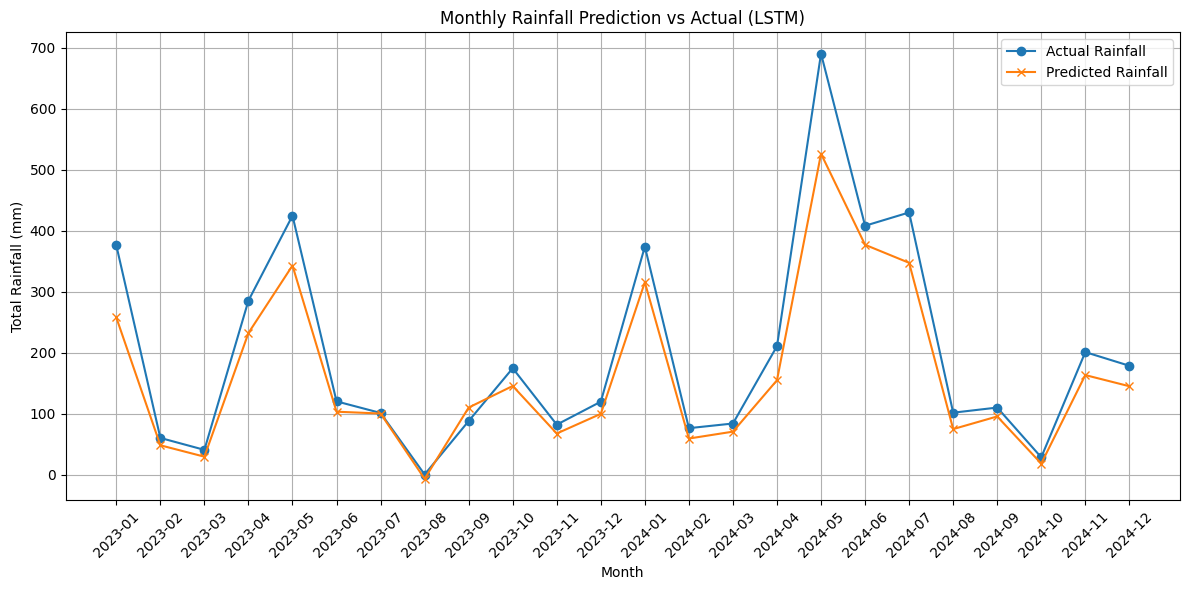

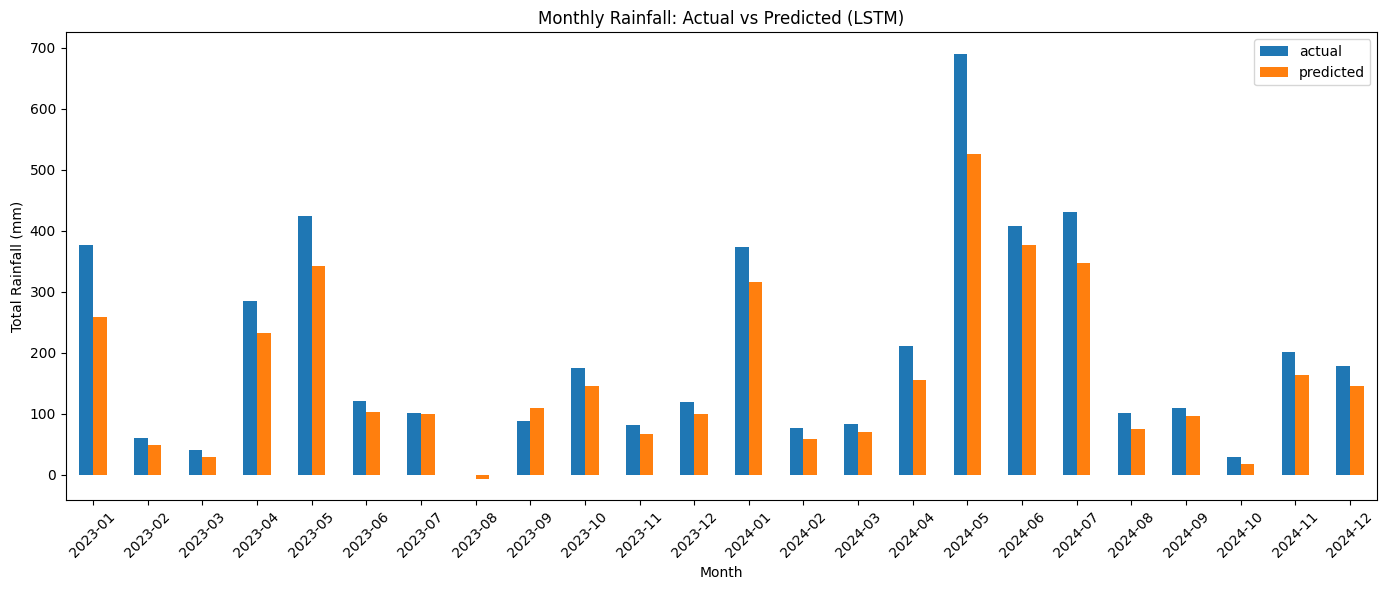

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Data Preprocessing
df = pd.read_csv("/content/combine.csv")
df['valid'] = pd.to_datetime(df['valid'])
df = df.sort_values('valid')
df_rain = df[['valid', 'p01m']].copy()
df_rain.set_index('valid', inplace=True)
df_rain = df_rain.fillna(0)


scaler = MinMaxScaler()
df_rain['p01m'] = scaler.fit_transform(df_rain[['p01m']])

# Create sequences
def create_sequences(data, seq_length):
    xs, ys, timestamps = [], [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        ts = df_rain.index[i+seq_length]
        xs.append(x)
        ys.append(y)
        timestamps.append(ts)
    return np.array(xs), np.array(ys), np.array(timestamps)

seq_length = 30
X, y, ts = create_sequences(df_rain['p01m'].values, seq_length)

# Split Data
split_date = pd.to_datetime("2023-01-01")
train_idx = ts < split_date
test_idx = (ts >= split_date) & (ts <= pd.to_datetime("2024-12-31"))

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]
timestamps = ts[test_idx]


X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

# Define Model Structure
class RainfallModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(RainfallModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Load the Trained Model
model_path = '/content/lstm_rainfall_model.pth'
model = RainfallModel()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()


with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
y_pred = y_pred_tensor.squeeze().numpy()


y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot Line Graph
df_test = pd.DataFrame({
    'valid': timestamps,
    'actual': y_true_inv,
    'predicted': y_pred_inv
})
df_test['year_month'] = df_test['valid'].dt.to_period('M')
monthly = df_test.groupby('year_month')[['actual', 'predicted']].sum().reset_index()
monthly['year_month'] = monthly['year_month'].astype(str)

plt.figure(figsize=(12, 6))
plt.plot(monthly['year_month'], monthly['actual'], marker='o', label='Actual Rainfall')
plt.plot(monthly['year_month'], monthly['predicted'], marker='x', label='Predicted Rainfall')
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Rainfall (mm)")
plt.title("Monthly Rainfall Prediction vs Actual (LSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Bar Graph
monthly.plot(
    x='year_month',
    y=['actual', 'predicted'],
    kind='bar',
    figsize=(14, 6),
    title="Monthly Rainfall: Actual vs Predicted (LSTM)"
)
plt.xlabel("Month")
plt.ylabel("Total Rainfall (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


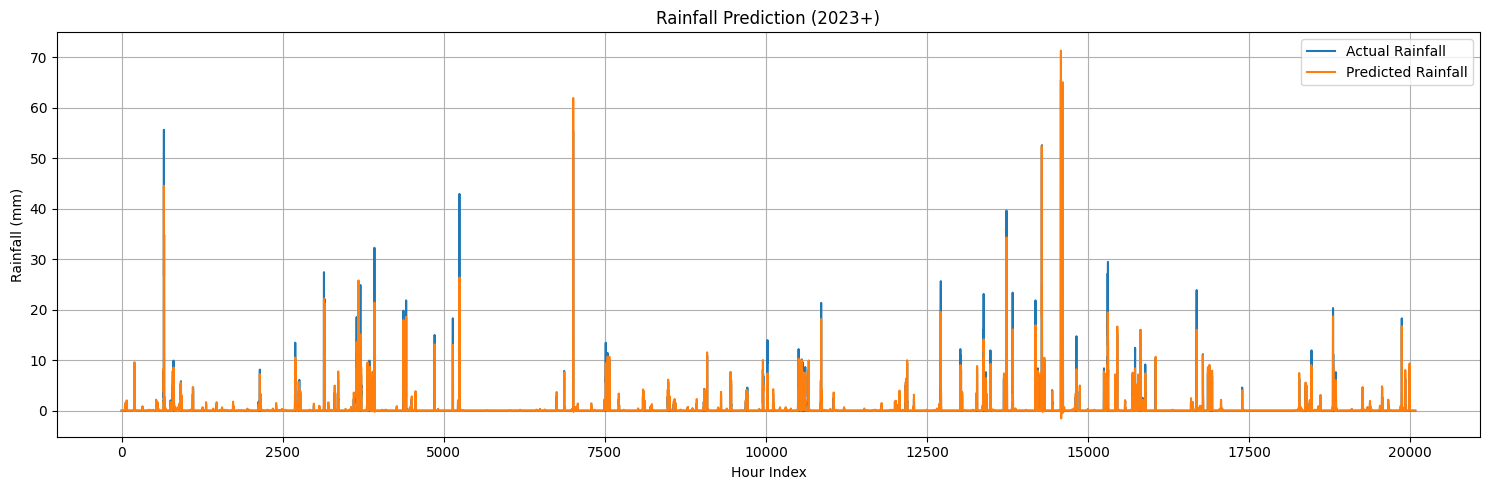

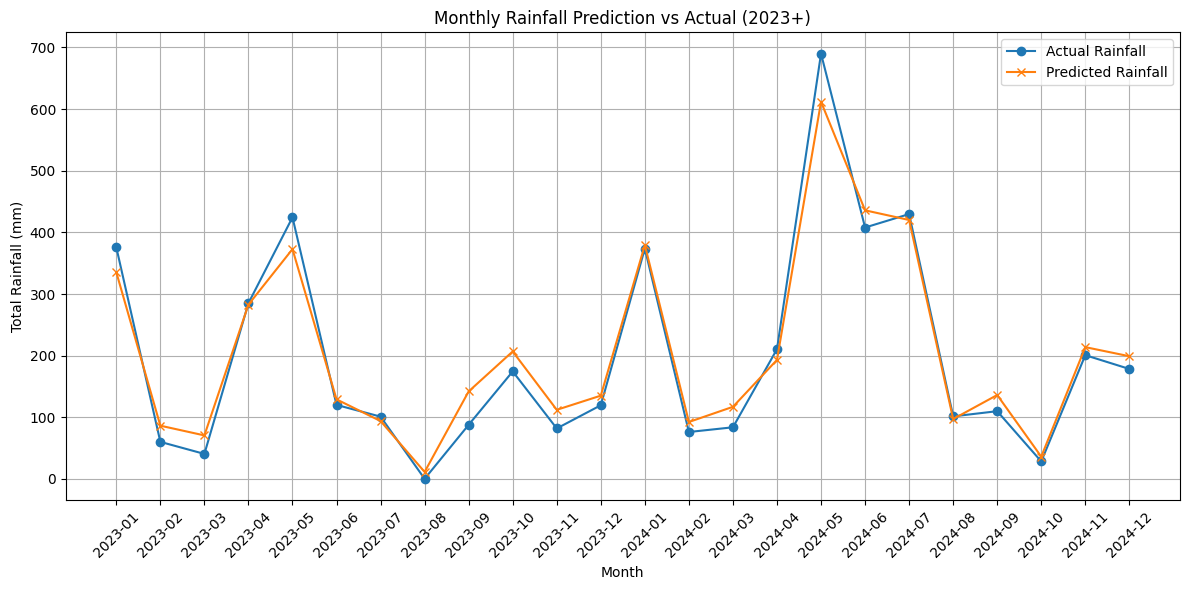

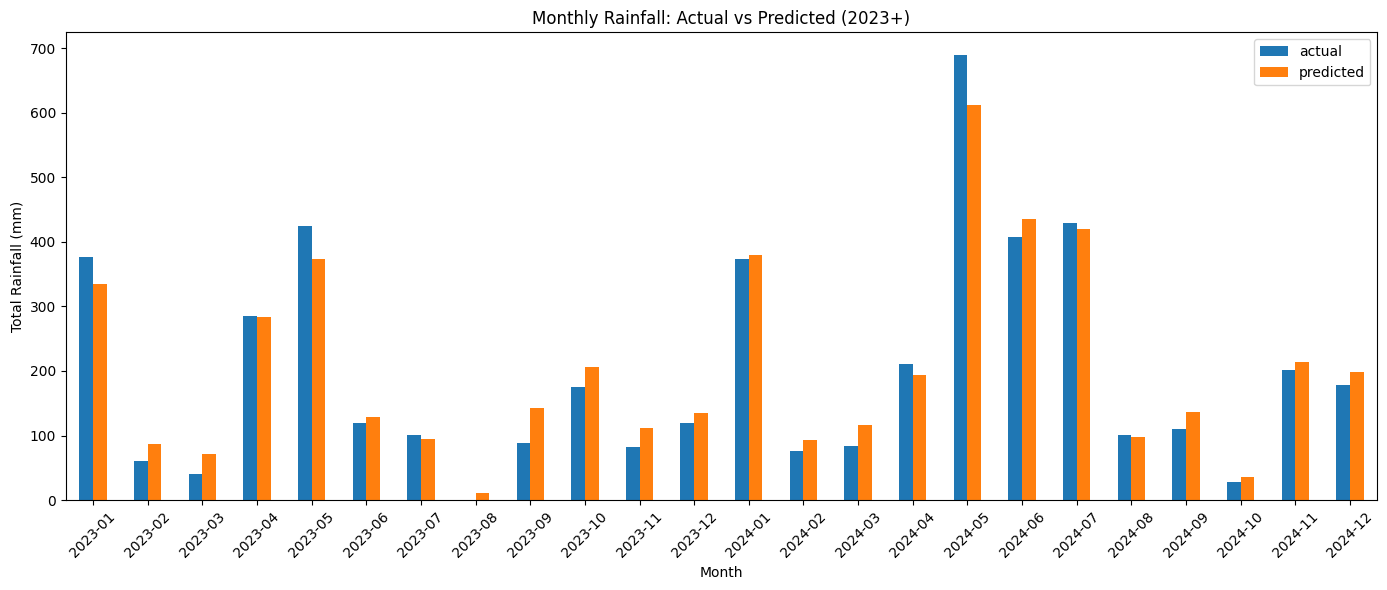

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/combine.csv')
df['valid'] = pd.to_datetime(df['valid'])
df = df.sort_values('valid').reset_index(drop=True)
df['p01m'] = df['p01m'].fillna(0)

# Extract time features
df['hour'] = df['valid'].dt.hour
df['dayofweek'] = df['valid'].dt.dayofweek
df['month'] = df['valid'].dt.month
df['year'] = df['valid'].dt.year

# Create lag features
for lag in range(1, 25):
    df[f'lag_{lag}'] = df['p01m'].shift(lag)

df = df.dropna().reset_index(drop=True)

# Prepare input/output
X = df.drop(columns=['valid', 'station', 'lon', 'lat', 'elevation', 'p01m'])
y = df['p01m']

# Split data
test_mask = df['year'] >= 2023
X_test = X[test_mask]
y_test = y[test_mask]
X_train = X[~test_mask]
y_train = y[~test_mask]


xgb_model = xgb.XGBRegressor()
xgb_model.load_model('/content/xgb_rainfall_model.json')


y_pred = xgb_model.predict(X_test)

# Plot predictions
plt.figure(figsize=(15, 5))
plt.plot(y_test.values, label='Actual Rainfall')
plt.plot(y_pred, label='Predicted Rainfall')
plt.title("Rainfall Prediction (2023+)")
plt.xlabel("Hour Index")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df_test = df[test_mask].copy().reset_index(drop=True)

df_test['actual'] = y_test.values
df_test['predicted'] = y_pred
df_test['year_month'] = df_test['valid'].dt.to_period('M')

monthly = df_test.groupby('year_month')[['actual', 'predicted']].sum().reset_index()
monthly['year_month'] = monthly['year_month'].astype(str)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly['year_month'], monthly['actual'], marker='o', label='Actual Rainfall')
plt.plot(monthly['year_month'], monthly['predicted'], marker='x', label='Predicted Rainfall')
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Rainfall (mm)")
plt.title("Monthly Rainfall Prediction vs Actual (2023+)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

monthly.plot(
    x='year_month',
    y=['actual', 'predicted'],
    kind='bar',
    figsize=(14, 6),
    title="Monthly Rainfall: Actual vs Predicted (2023+)"
)
plt.xlabel("Month")
plt.ylabel("Total Rainfall (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [1]:
import pandas as pd
df=pd.read_csv('/content/combine.csv',index_col='valid'   ,parse_dates=True)
df=df.dropna()
print('Shape of data',df.shape)
df.head()
df

FileNotFoundError: [Errno 2] No such file or directory: '/content/combine.csv'